# Figure: Cal beads simulation

Neerja Aggarwal
May 20th, 2024
Purpose: simulate measurement and reconstruction from different optical configurations.


## Import

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
import os
import sys
sys.path.append("../") # needed to bring in sdc module
import sdc_config5 as sdc
import sdc_config3 as sdc_np
import jax.numpy as jnp
import jax
import optax
# figures helper functions
%run figures_util.py
# from cleanplots import *

# CHOOSE GPU
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../')
gpu = 3

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_LAUNCH_BLOCKING'] = str(1) # get more error messages
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #stop jax from preallocating 75% of the gpu

## System Parameters

In [2]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 1
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

mag_size = 4*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor
gt_pixel_size = 4.4 # um
gt_mag_size = 4*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um



## choose spectra

Ho.csv
Tm.csv
Eu.csv
Sm.csv
Er.csv
Dy.csv


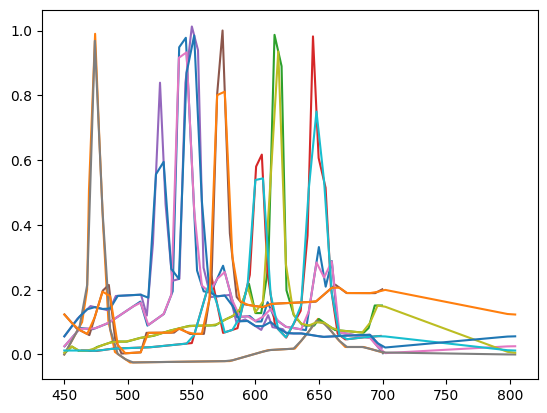

In [3]:
# choose spectra here. 
datafolder = '/home/neerja/DATA/SDCData/mrbles_spectra'
mrbles = dict()
k = 0
for fname in os.listdir(datafolder):
    print(fname)
    # import csv file 
    # store into some structure - dictionary?    
    # plot all
    spectra = np.genfromtxt(os.path.join(datafolder,fname), delimiter=",")
    mrbles[k] = spectra[1:,:] #skip x y -> nan column label
    plt.plot(spectra[:,0],spectra[:,1])
    k = k+1

# decide wavelength sampling

mrblesnew = np.zeros((len(mrbles),len(wavelengths)))
for k in range(len(mrbles)):
    spec = mrbles[k]
    spec = np.insert(spec,0,[wvmin,spec[0,1]],axis=0)
    spec = np.append(spec,[[wvmax,spec[0,-1]]],axis=0)
    spec = np.delete(spec, spec[:,0]<wvmin,0) #delete outside wvchannels
    spec = np.delete(spec, spec[:,0]>wvmax,0)
    # interpolate #improve the interpolation
    specnew = np.interp(wavelengths,spec[:,0],spec[:,1]) #interpolate to wvchannels
    mrblesnew[k,:] = specnew
    plt.plot(wavelengths,specnew)

806


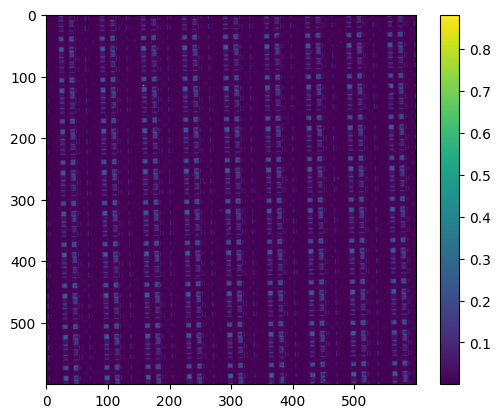

In [4]:
calibration_location = '../'
psf_name = 'recon_materials_organized/psf_2023-11-16.pt'
filter_cube_file = 'Calibration_data/spectral_calibration_2024-02-23_8nmFWHM.pt'  # 'filter_stack' # use new one from 2024
crop_indices = [600,1200,1400,2000] #top bottom left default: [320,1652,1350,2726]

# Load and crop filter cube
spectral_filter_data = torch.load(os.path.join(calibration_location,filter_cube_file),map_location='cpu')
filterstack = sdc.cropci(spectral_filter_data['filter_stack'], crop_indices)

wv = torch.Tensor(spectral_filter_data['wavelength'])
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)
spectral_filter = msum/torch.amax(msum)
(dim0,dim1,dim2) = spectral_filter.shape

# Load and crop PSF
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
ccrop = torchvision.transforms.CenterCrop(spectral_filter.shape[1:]) # center the psf
psf = ccrop(sensor_psf)
psf = psf.clip(0) # clip negative values to 0
psf = psf/torch.sum(psf) # l1 normalize the psf
hpad = sdc.pad(psf) # normalize
hfftpad = torch.fft.fft2(hpad)

plt.imshow(spectral_filter[0,:,:])
plt.colorbar()

# Draw CAL

In [5]:
#initialize x 
#choose size for beads. 
import imgviz

def placeBead(src, bcenter, bdiam, spectra=None):
    #place bead at location
    #if its a flat 2d image, then just place bead and return image
    if len(src.shape)<= 2:
        xout = imgviz.draw.circle(src, bcenter, bdiam, fill=1)
        return xout
    #else if it's 3d image, then place bead with spectra
    if len(src.shape)>2:
        xoutfull = src #make a copy to be safe
        #get index of where bead should go
        xout = imgviz.draw.circle(src[:,:,0], bcenter, bdiam, fill=1)
        a = np.where(xout ==1)
        pmax = len(a[0])
        for p in range(pmax):
            yval = a[0][p]
            xval = a[1][p]
            xoutfull[yval,xval,:] = spec
        return xoutfull
    return src

def genBeadloc(src,numBeads,specnum=1,buffer=0):
    (dim0,dim1,dim2) = src.shape
    yloc = np.random.randint(0+buffer,dim0-buffer,numBeads)
    xloc = np.random.randint(0+buffer,dim1-buffer,numBeads)
    s = np.random.randint(0,specnum,numBeads)
    return (yloc,xloc,s)

#use draw.circle to get indices
#then change indices myself

(-0.5, 599.5, 599.5, -0.5)

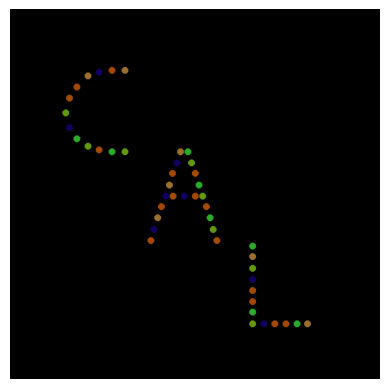

In [6]:
xsamples = dim1
ysamples = dim2
bead_loc = []

#The Letter C
bead_loc.append((int(.28*xsamples),int(.15*ysamples)))
bead_loc.append((int(.32*xsamples),int(.16*ysamples)))
bead_loc.append((int(.24*xsamples),int(.16*ysamples)))
bead_loc.append((int(.21*xsamples),int(.18*ysamples)))
bead_loc.append((int(.35*xsamples),int(.18*ysamples)))
bead_loc.append((int(.18*xsamples),int(.21*ysamples)))
bead_loc.append((int(.37*xsamples),int(.21*ysamples)))
bead_loc.append((int(.17*xsamples),int(.24*ysamples)))
bead_loc.append((int(.38*xsamples),int(.24*ysamples)))
bead_loc.append((int(.165*xsamples),int(.275*ysamples)))
bead_loc.append((int(.385*xsamples),int(.275*ysamples)))
bead_loc.append((int(.165*xsamples),int(.31*ysamples)))
bead_loc.append((int(.385*xsamples),int(.31*ysamples)))


# The Letter A
bead_loc.append((int(.505*xsamples),int(.47*ysamples)))
bead_loc.append((int(.505*xsamples),int(.44*ysamples)))
bead_loc.append((int(.505*xsamples),int(.5*ysamples)))
for ii in range(1,10):
    bead_loc.append((int((.355+ii*.03)*xsamples),int((.47+ii*.01)*ysamples)))
    bead_loc.append((int((.355+ii*.03)*xsamples),int((.47-ii*.01)*ysamples)))


# The Letter L
for ii in range(1,9):
    bead_loc.append((int((.61+ii*.03)*xsamples),int(.655*ysamples)))
for ii in range(1,7):
    bead_loc.append((int(.85*xsamples),int((.625+ii*.03)*ysamples)))

bdiam = 10
xinit = np.zeros_like(msum)   
# reorder the dimensions to be compatible with the function
xinit = np.transpose(xinit, (1, 2, 0))
for k in range(len(bead_loc)):
    #spec = mrblesnew[torch.randint(5,(1,1)),:]
    spec = mrblesnew[np.mod(k,len(mrblesnew)),:] #cycle through
    xcal = placeBead(xinit, bead_loc[k],bdiam, spectra = spec)

plt.figure()
HSI_data = np.reshape(xcal, [-1,dim0])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
plt.imshow(false_color)
plt.axis('off')

### diffuser measurement

In [7]:
# simulate regular diffusercam forwrd model. 
# Load and crop PSF
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
ccrop = torchvision.transforms.CenterCrop(spectral_filter.shape[1:]) # center the psf
psf = ccrop(sensor_psf)
psf = psf.clip(0) # clip negative values to 0
psf = psf/torch.sum(psf) # l1 normalize the psf
psf_diffuser = psf
x = np.transpose(xcal, (2, 0, 1))
# move calibration to jax
hpad = jnp.asarray(sdc.pad(psf_diffuser))
hfftpad = jnp.fft.fft2(hpad)[None, ...]
m = jnp.asarray(spectral_filter)
y_diffuser = sdc.jax_forward_model(x, m, hfftpad)

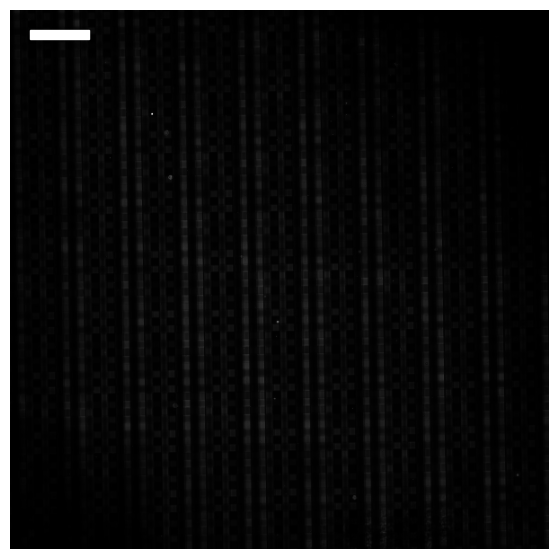

In [8]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_diffuser**1, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.02])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### original measurement

In [9]:
# simulate with delta psf. 
psf_delta = torch.zeros_like(psf)
psf_delta[psf_delta.shape[0]//2,psf_delta.shape[1]//2] = 1

hpad = jnp.asarray(sdc.pad(psf_delta))
hfftpad = jnp.fft.fft2(hpad)[None, ...]
y_delta = sdc.jax_forward_model(x, m, hfftpad)

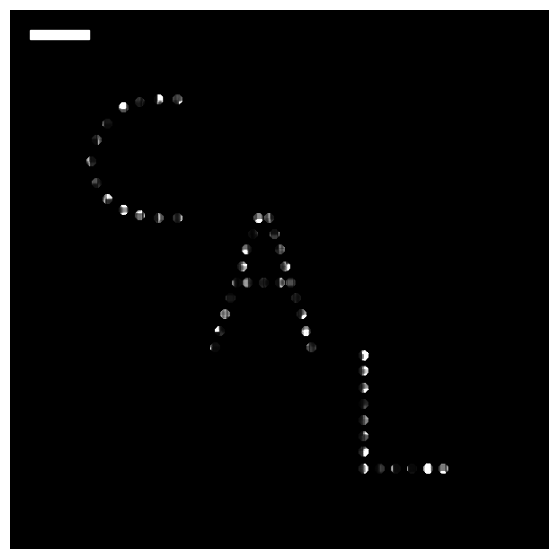

In [10]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_delta**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.5])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### magnified measurement

In [11]:
from jax.image import resize
# Define the scale factor and new shape
scale_factor = 8
zoom_size = (int(x.shape[1]/scale_factor), int(x.shape[2]/scale_factor))
# crop the original image
xzoom = sdc.crop(torch.Tensor(x), zoom_size)

# Scale the array using bilinear interpolation
xmag = resize(np.asarray(xzoom), x.shape, method='linear')
y_mag = sdc.jax_forward_model(xmag, m, hfftpad)

(-0.5, 599.5, 599.5, -0.5)

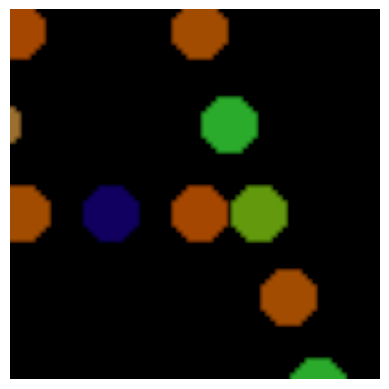

In [12]:
plt.figure()
HSI_data = np.reshape(np.transpose(xmag, (1,2,0)), [-1,dim0])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
plt.imshow(false_color)
plt.axis('off')

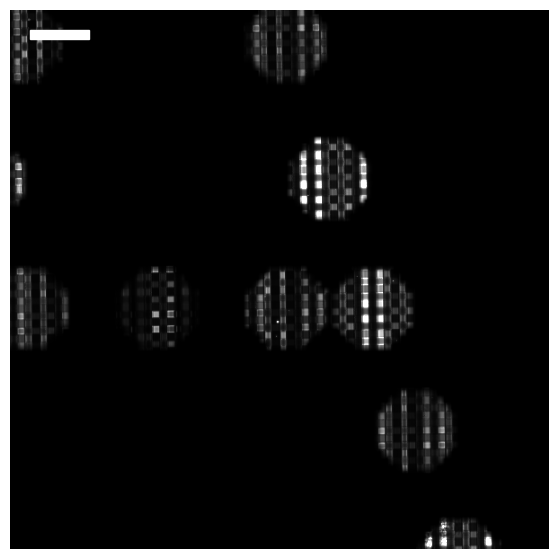

In [13]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_mag**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,1])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

## defocused measurement

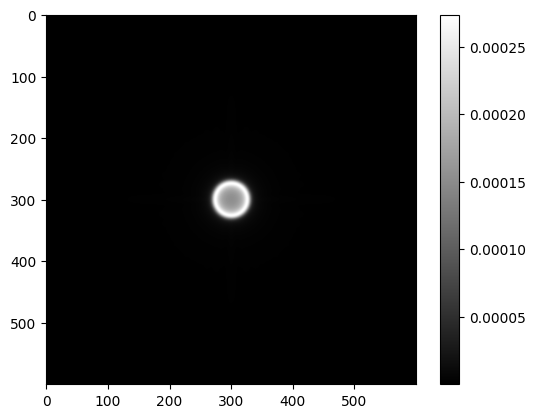

In [14]:
# use simulation to get defocused psf. 

# create quadratic phase...
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
size = [psf.shape[0],psf.shape[1]] # Grid size
source = np.array([0,0, 0])  # Source location (y,x,z) in micron
wavelength = 500e-3 # Wavelength # 500 nm in um
pixsize =  wavelength/20 # Pixel size in micron
amplitude = 1  # Wave amplitude

# Create a 2D grid
x1 = np.linspace(-size[1]*pixsize/2, size[1]*pixsize/2, size[1])
y1 = np.linspace(-size[0]*pixsize/2, size[0]*pixsize/2, size[0])
z1 = 2  # microns above source
X, Y= np.meshgrid(x1, y1)

# Calculate the distance from the source
R = np.sqrt((X - source[1])**2 + (Y - source[0])**2 + (z1 - source[2])**2)

# Calculate the phase
phase = 2*np.pi/wavelength * R
amp = amplitude/R
# circle aperture
aperture = np.zeros_like(X)
r = np.sqrt((X)**2 + (Y)**2)
aperture[r<np.amax(X)] = 1

uxy = amp*np.exp(1j * phase)*aperture

fuxy = np.fft.fftshift(np.fft.fft2(uxy))

from scipy.ndimage import gaussian_filter
psf_defocus = np.abs(gaussian_filter(np.abs(fuxy), sigma=3))
psf_defocus = psf_defocus/np.sum(psf_defocus)

plt.figure()
plt.imshow(psf_defocus, cmap = 'gray')
plt.colorbar()


/tmp/ipykernel_512356/1575900754.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  defocused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_defocused.bmp'))
/tmp/ipykernel_512356/1575900754.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  focused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_focused.bmp'))


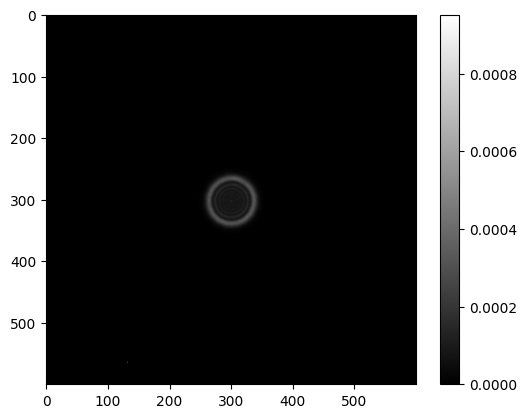

In [24]:
# use measurement instead. 
# read numpy array from image
import imageio

# Load the BMP image
defocused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_defocused.bmp'))
focused_bmp = np.array(imageio.imread('Figures/calbeadsim/christian_focused.bmp'))

cen = np.argmax(focused_bmp)
cen = np.unravel_index(cen, focused_bmp.shape)

#crop arround defocused image

psf_defocus = defocused_bmp[cen[0]-int(psf_diffuser.shape[0]/2):cen[0]+int(psf_diffuser.shape[0]/2),cen[1]-int(psf_diffuser.shape[1]/2):cen[1]+int(psf_diffuser.shape[1]/2)]
# Convert the image to a numpy array
#subtract background
psf_defocus = psf_defocus - np.amin(psf_defocus)
psf_defocus = psf_defocus/np.sum(psf_defocus)
plt.imshow(psf_defocus, cmap = 'gray')
plt.colorbar()

In [26]:
# simulate with blur psf.
hpad = jnp.asarray(sdc.pad(torch.Tensor(psf_defocus)))
hfftpad = jnp.fft.fft2(hpad)[None, ...]
y_defocus = sdc.jax_forward_model(x, m, hfftpad)


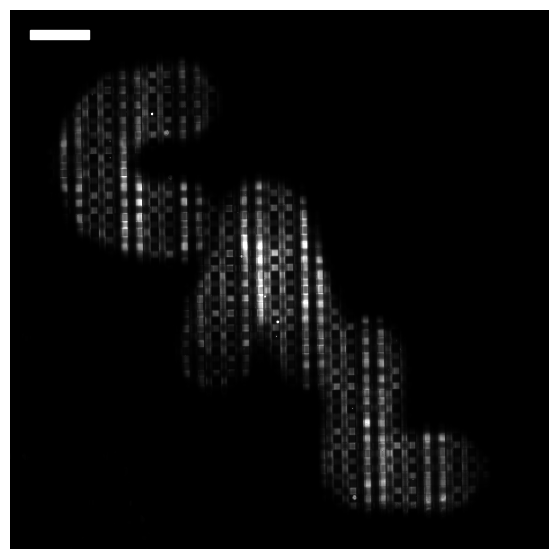

In [32]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_defocus**1, cmap='gray')
# plt.colorbar()
plt.clim([0,.07])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

### blurred measurement


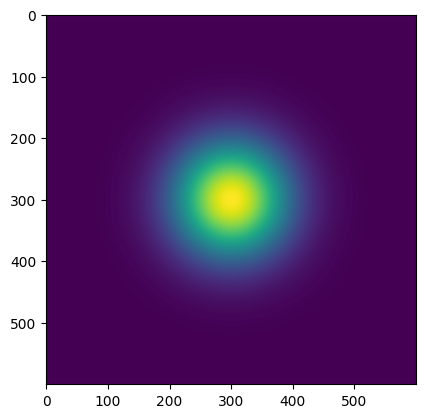

In [33]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Create a PSF with a Gaussian blur
psf_blur = np.zeros_like(psf)
psf_blur[int(psf_blur.shape[0] / 2), int(psf_blur.shape[1]/2)] = 1.0  # Set the center pixel to 1.0
psf_blur = gaussian_filter(psf_blur, sigma=66.0)  # Apply Gaussian blur with sigma=1.0

# Normalize the PSF
psf_blur /= np.sum(psf_blur)

plt.imshow(psf_blur)

In [34]:
# simulate with blur psf. 
hpad = jnp.asarray(sdc.pad(torch.Tensor(psf_blur)))
hfftpad = jnp.fft.fft2(hpad)[None, ...]
y_blur = sdc.jax_forward_model(x, m, hfftpad)

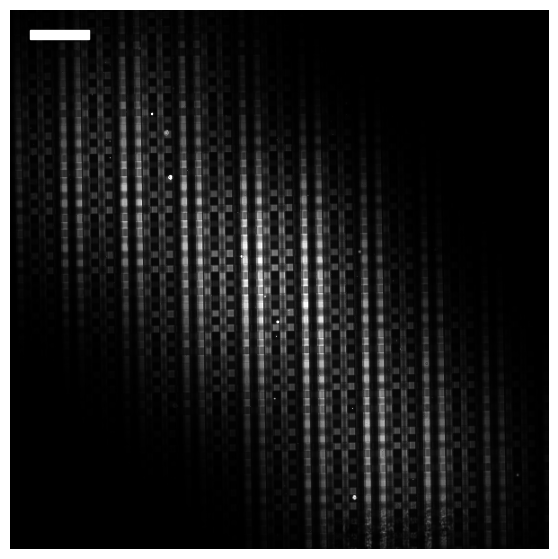

In [35]:
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(y_blur**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.03])
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname = '')
ax.add_artist(scalebar)

## add noise to the measurements

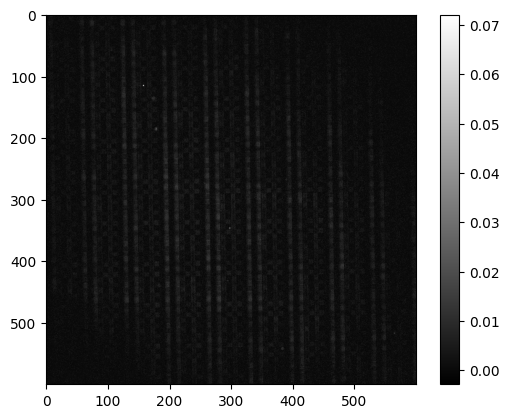

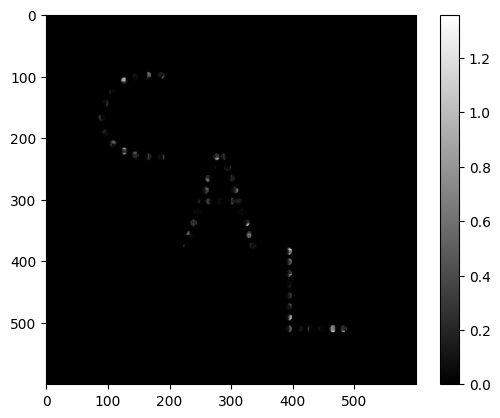

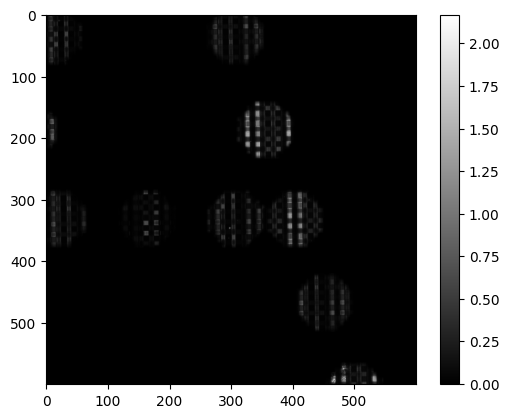

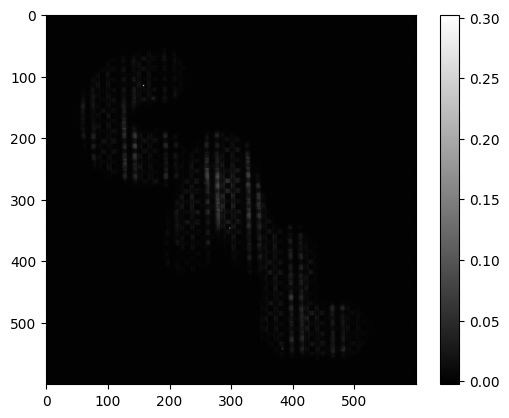

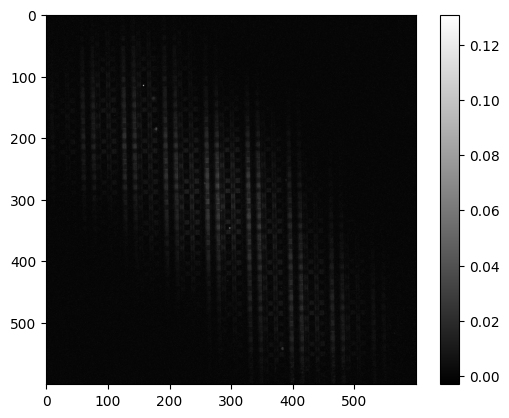

In [36]:
# stack all the measurements and psfs
meas_stack = [y_diffuser, y_delta, y_mag, y_defocus, y_blur]
psf_stack = [psf_diffuser, psf_delta, psf_delta, psf_defocus, psf_blur]
scale_factor_to_int = 2**16
noisy_meas_stack = [np.zeros_like(meas) for meas in meas_stack]
poisson_lambda_scale = 1
gaussian_noise_std = 100 # add some noise to the background dark pixels

for k in range(len(meas_stack)):
    meas = meas_stack[k]
    meas_int = (meas*scale_factor_to_int).astype(np.int32)
    poisson_noise = np.random.poisson(meas_int/poisson_lambda_scale)
    gauss_noise = np.random.normal(0,gaussian_noise_std, size = meas.shape)
    noisy_meas = (poisson_noise+meas_int+gauss_noise)/scale_factor_to_int
    # clip negative values to zero. 
    noisy_meas = jnp.where(noisy_meas < 0, 0, noisy_meas)
    noisy_meas_stack[k] = noisy_meas
    plt.figure()
    plt.imshow(noisy_meas_stack[k]-meas, cmap = 'gray')
    plt.colorbar()
# do we need to normalize the measurements before adding noise?  Maybe not.  But we will do afterwards to aid with the recon?




## Do the reconstructions

0


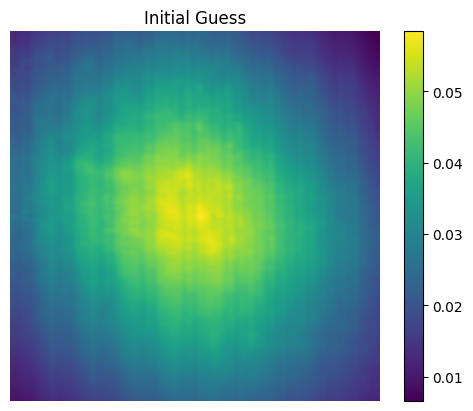

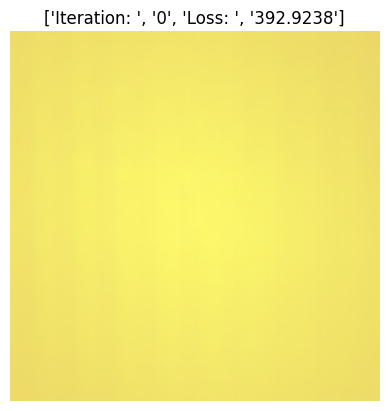

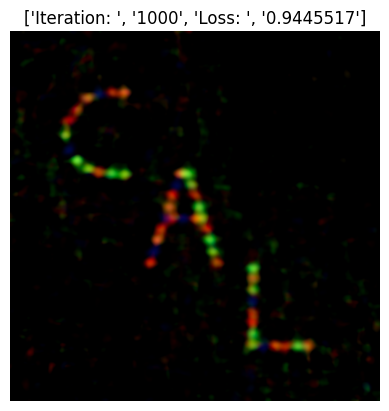

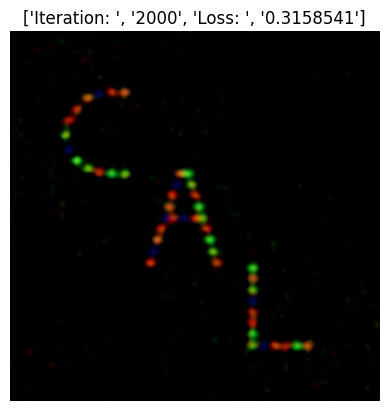

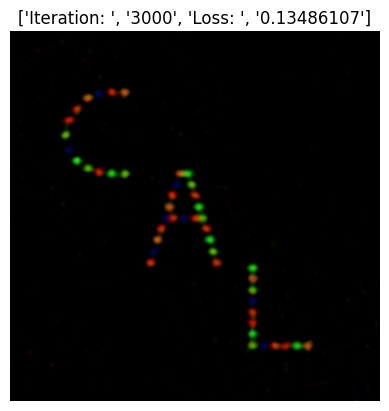

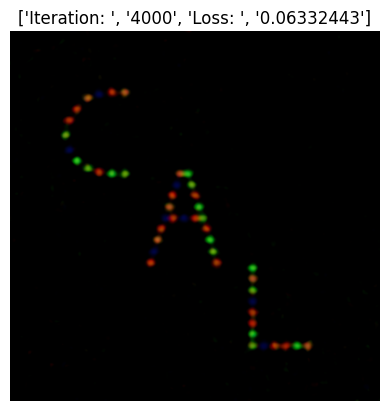

1


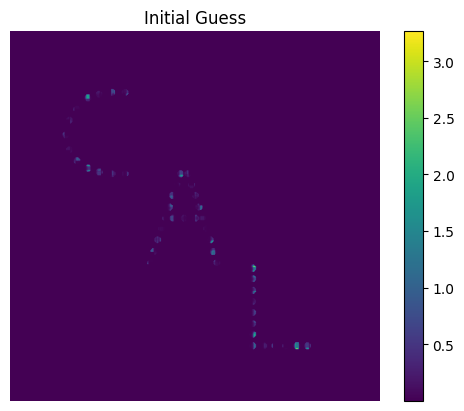

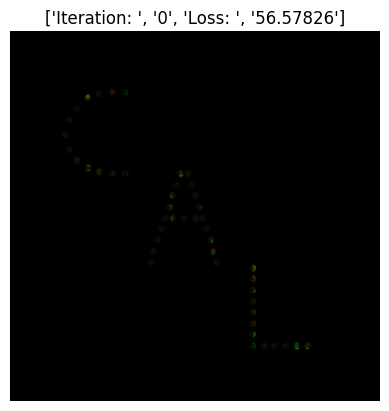

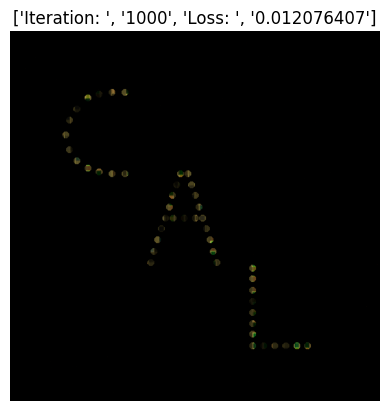

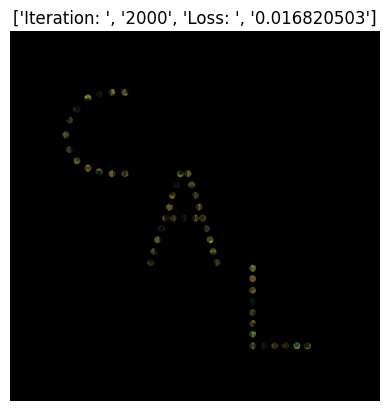

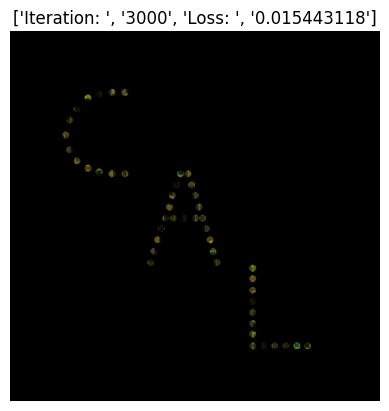

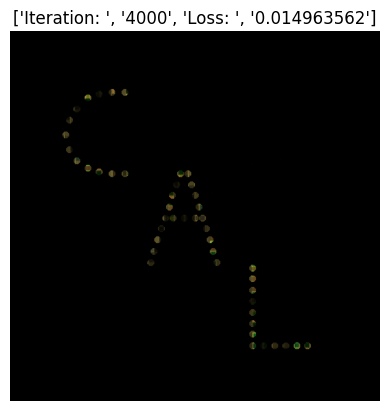

2


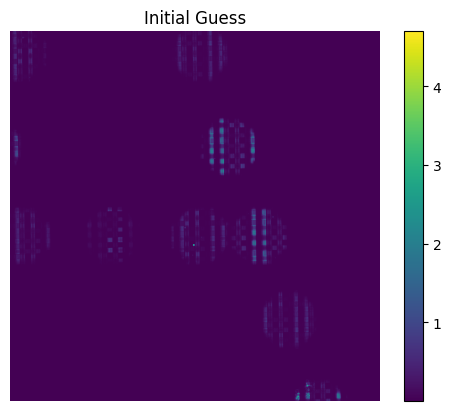

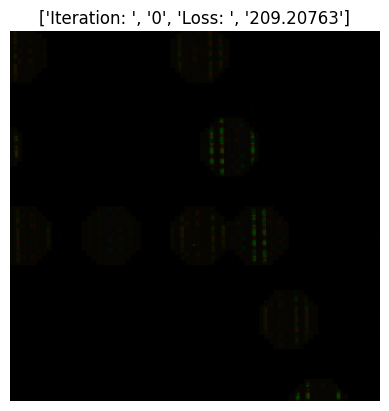

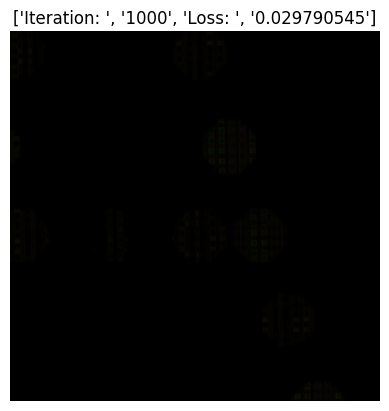

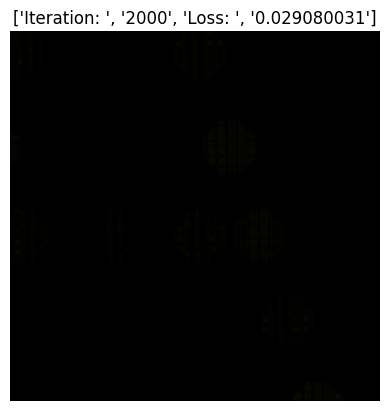

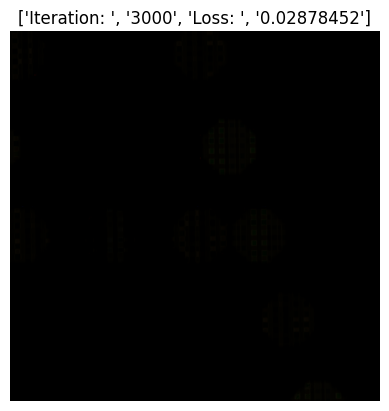

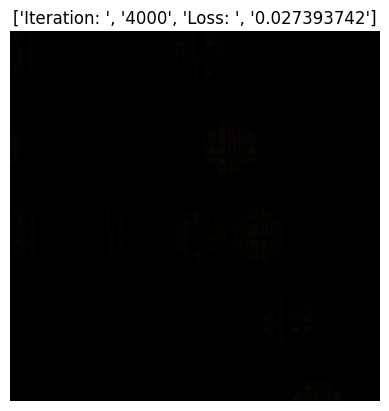

3


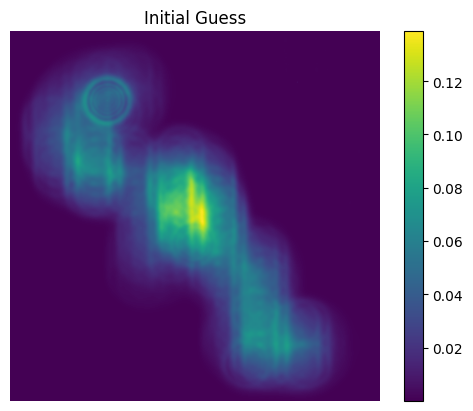

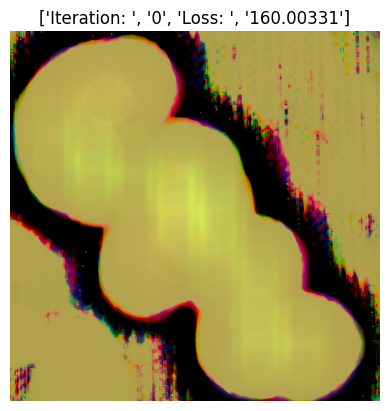

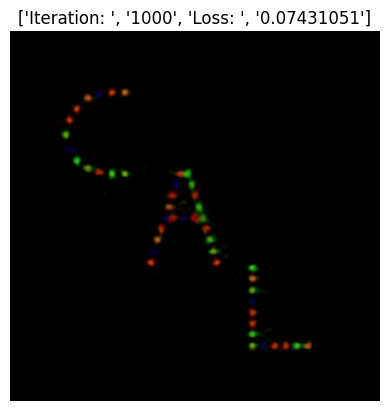

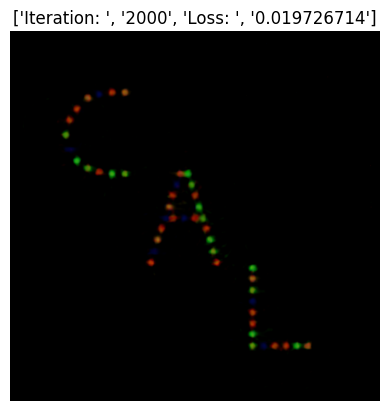

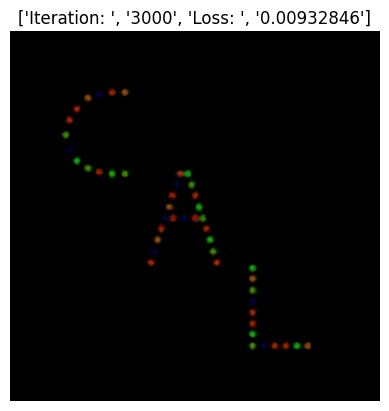

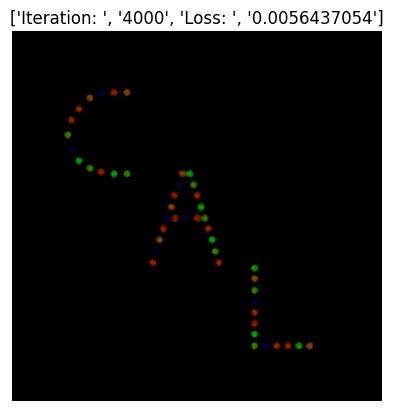

4


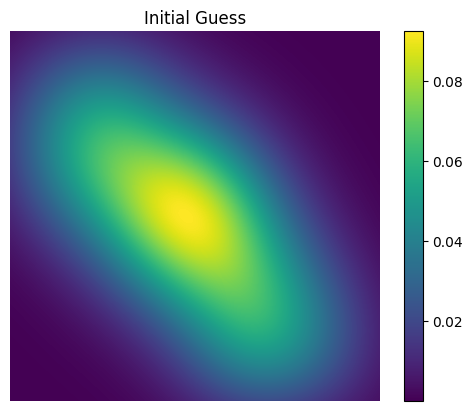

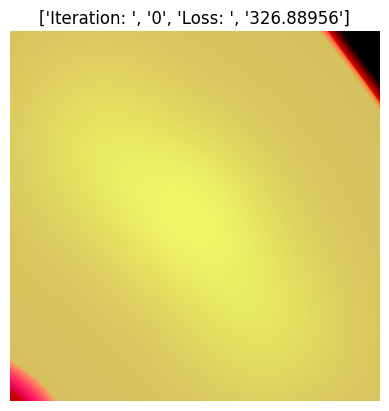

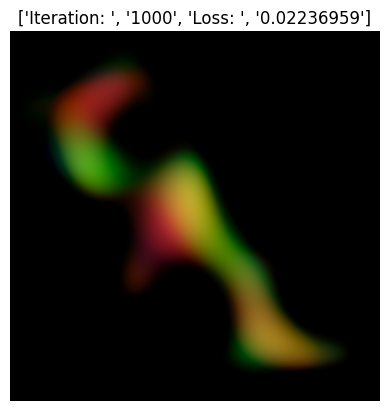

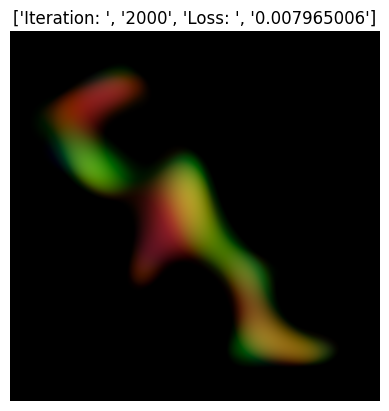

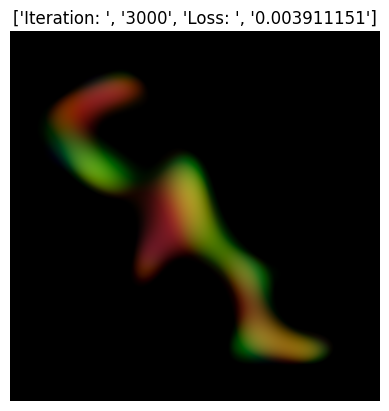

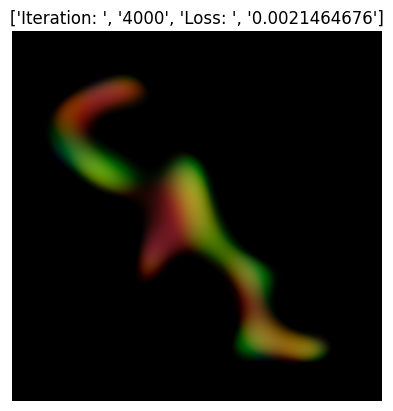

In [37]:
# do recon on diffuser measurement
# define the optimizer
kmax = 5000
kprint = 1000 #show halfway
step_size = 1e-2
thr = 0 #6e-5 #3e-6 is ok
xytv =  0 #1e-6 #1e-4 is big
lamtv = 0#  2e-6 #2e-6 is ok
optimizer = optax.adam(learning_rate=step_size)

# define a function to calculate the gradient and return the loss
loss_and_grad = jax.jit(jax.value_and_grad(sdc.loss_func, (0)))
# initialize the reconstruction
xk_stack = [np.zeros_like(x) for l in range(len(meas_stack))]

for k0 in range(len(meas_stack)):
    print(k0)
    meas = meas_stack[k0]
    psf = psf_stack[k0]
    hpad = jnp.asarray(sdc.pad(torch.Tensor(psf)))
    hfftpad = jnp.fft.fft2(hpad)[None, ...]
    m = jnp.asarray(spectral_filter)
    meas = jnp.asarray(meas/np.amax(meas))

    padding = ((0,0,0),(np.ceil(m.shape[1]/2).astype(int),np.floor(m.shape[1]/2).astype(int),0),(np.ceil(m.shape[2]/2).astype(int),np.floor(m.shape[2]/2).astype(int),0))
    # calculate the adjoint
    xk = sdc.jax_adjoint_model(meas, m, hfftpad, padding)
    # Initialize optimizer state
    opt_state = optimizer.init(xk)  
    plt.figure()
    plt.imshow(np.sum(xk,axis=0))
    plt.axis('off')
    plt.colorbar()
    plt.title('Initial Guess')
    plt.show()

    for k in range(kmax):
        loss, grad = loss_and_grad(xk, meas, m, hfftpad, thr, xytv, lamtv)
        updates, opt_state = optimizer.update(grad, opt_state)
        updates = jnp.nan_to_num(updates)
        # break
        xk = optax.apply_updates(xk, updates)
        xk = jnp.clip(xk, 0, None)
        if k%kprint == 0:
            HSI_data = np.reshape(np.transpose(xk, (1,2,0)), [-1,dim0])
            false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
            plt.figure()
            plt.imshow(false_color**1.8)
            plt.axis('off')
            plt.title(['Iteration: ', str(k), 'Loss: ', str(loss)])
            # plt.colorbar()
            plt.show()
    # save the reconstruction
    xk_stack[k0] = xk


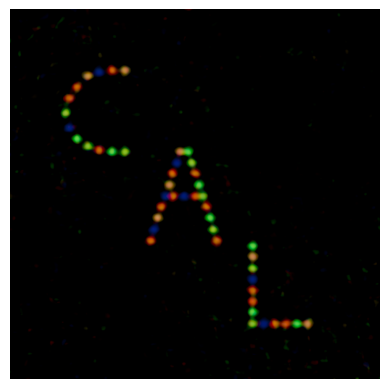

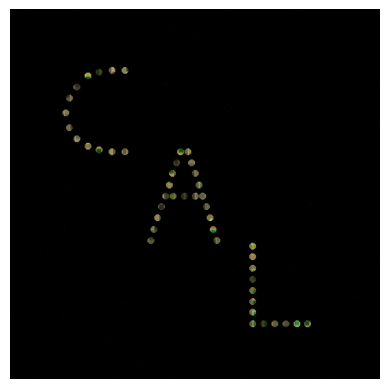

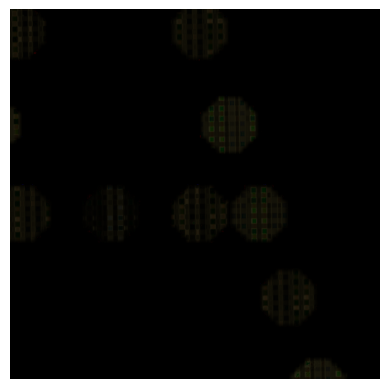

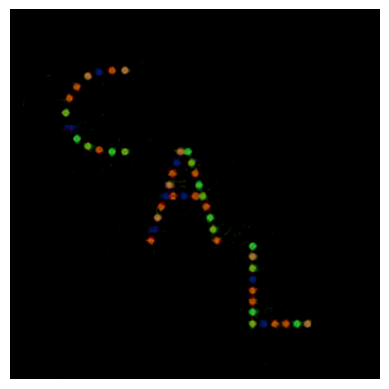

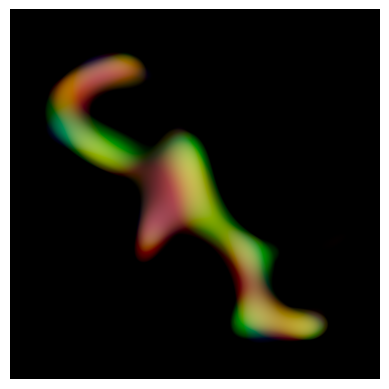

In [38]:
# plot final result. 
for k0 in xk_stack:
    HSI_data = np.reshape(np.transpose(k0, (1,2,0)), [-1,dim0])
    false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,dim1,dim2, 75, False)
    plt.figure()
    plt.imshow(false_color**1)
    plt.axis('off')
    # plt.colorbar()

In [184]:

# # Create a dictionary
# x_dict = {}

# x_dict['x_mag'] = x_mag
# x_dict['x_blur'] = x_blur
# x_dict['x_delta'] = x_delta
# x_dict['x_diffuser'] = x_diffuser
# x_dict['x_gt'] = x

# import pickle
# # Specify the file path where you want to save the dictionary
# file_path = './Figures/calbeadsim/x_recons.pkl'

# # Save the dictionary to the file
# with open(file_path, 'wb') as file:
#     pickle.dump(x_dict, file)
# # Print the dictionary
# print(x_dict)

{'x_mag': Array([[[3.4455545e-02, 3.5274789e-02, 7.5399995e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.4754336e-02, 3.5522029e-02, 7.4589446e-02, ...,
         0.0000000e+00, 0.0000000e+00, 9.4611907e-10],
        [3.3117846e-02, 3.2262791e-02, 6.7715615e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.4463752e-02, 3.5255618e-02, 7.5364724e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.4742568e-02, 3.5507713e-02, 7.4567370e-02, ...,
         0.0000000e+00, 0.0000000e+00, 2.2783935e-09],
        [3.3104122e-02, 3.2249074e-02, 6.7699686e-02, ...,
    

In [ ]:
## try to add more noise to defocus psf?
